Data Manipulation and Regression 
==========

- A notebook by Jacob Eisenstein in 2019

One of the early demonstrations of the power of social media to offer observational insights about large populations is the 2011 paper by Scott Golder and Michael Macy, [Diurnal and Seasonal Mood Vary with Work, Sleep, and DaylengthAcross Diverse Cultures](https://pdfs.semanticscholar.org/d087/5a52e332e716ca84d60d44954c1d9b4f6143.pdf) (G&M).

In this paper, G&M apply the LIWC sentiment analysis model to Twitter, and report changes by hour, weekday, length of day, and country. They find that people consistently produce more positive tweets on the weekend, and more negative tweets late at night. 

In this notebook, we use data from G&M to attempt to replicate their results. Other objectives for this notebook include:

- **the Python data science stack**, including dataframes, plotting, and statistical analysis
- [**Simpson's paradox**](https://en.wikipedia.org/wiki/Simpson%27s_paradox), in which a result that appears in aggregated data does not appear in disaggregated data
- **multiple regression**, which can identify the impact of multiple predictors on an outcome variable.

To run this notebook, you will need to install some packages, perhaps through `conda` or `pip`.

```
conda install jupyter pandas numpy statsmodels seaborn matplotlib
```

```
pip install --user jupyter pandas numpy statsmodels seaborn matplotlib
```

# Dataframes

We'll start by loading in the replication data, which comes in the form of [CSV file](../data/golder_macy_prefix.txt'). 

To access this data in a useful form, we will load it as a **dataframe**. You can think of a dataframe as a spreadsheet (rows and columns of data) that you can control programmatically.

In python, the standard library for handling dataframes is `pandas`. Let's use `pandas` to load in the data.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/golder_macy_prefix.txt',delimiter='\t')

In [3]:
# the head command shows the first few lines of the data frame
df.head(3)

,hour,pa,na,uid
0,144,0.083333,0.023810,1
1,23,0.090278,0.027778,1
2,127,0.200000,0.000000,1


Each row is a single record, corresponding to a tweet, with the following fields:
- **hour**, which is computed per week, so that the maximum value is $24 * 7 - 1 = 167$
- **pa**: fraction of tokens in the tweet matching the **positive affect** lexicon in LIWC (see https://www.cs.cmu.edu/~ylataus/files/TausczikPennebaker2010.pdf)
- **na**: fraction of tokens matching LIWC's **negative affect** lexicon
- **uid**: a user identifier


In [4]:
# sanity check
print("max values:",df.max())
print()
print("min values:",df.min())

max values: hour     167.0
pa         1.0
na         1.0
uid     1956.0
dtype: float64

min values: hour    0.0
pa      0.0
na      0.0
uid     1.0
dtype: float64


To simplify the discussion, rather than treating positive and negative sentiment separately, let's aggregate them into a "sentiment ratio."

In [5]:
df['ratio'] = df['pa'] / (df['pa'] + df['na'] + 1e-10)

In [6]:
df.head(3)

,hour,pa,na,uid,ratio
0,144,0.083333,0.023810,1,0.777778
1,23,0.090278,0.027778,1,0.764706
2,127,0.200000,0.000000,1,1.000000


Success! The new field appears in the dataframe.

# Plotting the data

We want to test the following hypotheses:

- People are happier on the weekend
- People are less happy late at night

As a first step, let's plot the data. To do this, we will use the libraries `matplotlib` and `seaborn`.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

First, let's make a scatterplot between hour and sentiment ratio.

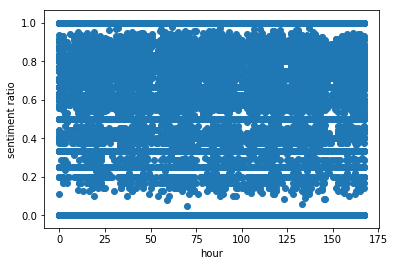

In [8]:
plt.scatter(df['hour'],df['ratio'])
plt.xlabel('hour')
plt.ylabel('sentiment ratio');

Not too useful! `seaborn` is a library designed for plotting from dataframes. Let's try using this instead.

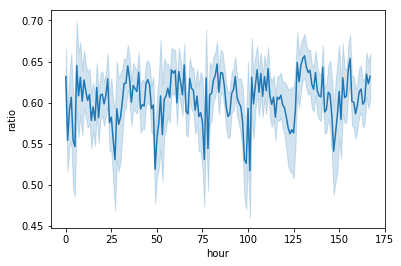

In [10]:
sns.lineplot(x='hour',y='ratio',data=df);

Better! The plot shows the mean sentiment per hour-of-the-week. The errorbars are a single standard deviation by default.

The eye test suggests that there is some structure in this data. Let's try and tease out time-of-day and day-of-week effects. We'll do this by adding additional fields to the data frame.

In [11]:
df['time_of_day'] = df['hour'] % 24
df['day_of_week'] = (df['hour']/24).apply(lambda x : int(x))

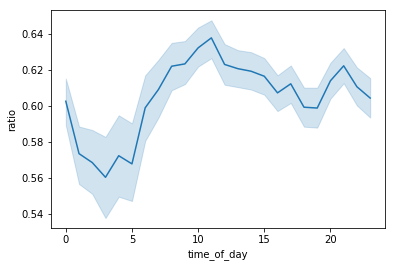

In [12]:
sns.lineplot(x='time_of_day',y='ratio',data=df);

This looks like good support for the hypothesis that people are less happy late at night: the sentiment ratio from 1-5am is much lower than the rest of the day. Now let's look at day-of-the-week.

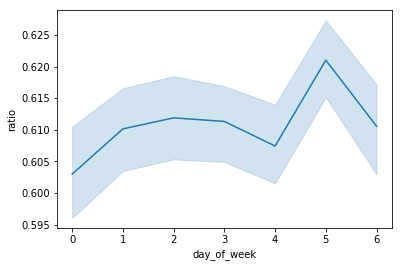

In [13]:
sns.lineplot(x='day_of_week',y='ratio',data=df);

Assuming saturday and sunday are coded with the final 48 hours, then this does look like evidence for the hypothesis that people are happier on the weekend, especially on Saturday. So the replication is a success! Unless...

# Simpson's Paradox

Consider the following scenario:

- On weekdays, people are generally unhappy, and post with equal probability at any hour
- On weekends, people are generally happy, and don't post at night

In this scenario, the time-of-day has no affect on sentiment! Yet we might see data in which time is correlated with sentiment, just as in the graphs above. We can see this by generating synthetic data according to the same scenario as above.

In [14]:
weekend_mean_ratio = 0.65 # mean sentiment on weekends
weekday_mean_ratio = 0.6 # mean sentiment on weekdays
weekday_N = 50000 #number of samples
weekend_N = 50000

First, let's generate the sentiment ratios. We'll use a Beta distribution, which generates values in the range $[0,1]$. To sample from this distribution, we'll use the `numpy` library for numerical computing (http://www.numpy.org/).

In [15]:
import numpy as np

In [16]:
scale = 2 # this controls the variance
weekday_ratios = np.random.beta(scale * weekday_mean_ratio,scale * (1 - weekday_mean_ratio),weekday_N)
weekend_ratios = np.random.beta(scale * weekend_mean_ratio,scale * (1 - weekend_mean_ratio),weekend_N)

Let's see if the generated data corresponds to our scenario.

In [17]:
print(f'weekday: {weekday_ratios.mean():0.3f} +- {weekday_ratios.std():0.3f}')
print(f'weekend: {weekend_ratios.mean():0.3f} +- {weekend_ratios.std():0.3f}')

weekday: 0.597 +- 0.284
weekend: 0.650 +- 0.275


Now let's genenerate the hours at which each message was posted. 
For weekend messages, this excludes the hours of 0-6am.

In [18]:
hours_weekday = np.random.randint(0,24,weekday_N)
hours_weekend = np.random.randint(6,24,weekend_N)

Finally, let's generate the day of the week.

In [19]:
days_weekday = np.random.randint(0,5,weekday_N)
days_weekend = np.random.randint(5,7,weekday_N)

Now let's wrap this all up into a new dataframe.

In [20]:
df_sim = pd.DataFrame({'time_of_day':np.hstack([hours_weekday,hours_weekend]),
                       'day_of_week':np.hstack([days_weekday,days_weekend]),
                       'ratio':np.hstack([weekday_ratios,weekend_ratios])})

df_sim.head(3)

,time_of_day,day_of_week,ratio
0,4,4,0.906327
1,1,4,0.757815
2,21,1,0.575748


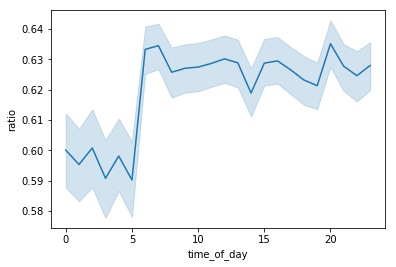

In [21]:
# now we plot it
sns.lineplot(x='time_of_day',y='ratio',data=df_sim);

Sentiment is more negative in the morning! Yet if we subdivide by day-of-the-week, the effect disappears.

In [22]:
# add a column indicating if the day of the week is a weekday or not
df_sim['weekday'] = df_sim['day_of_week'].apply(lambda x : x < 5)

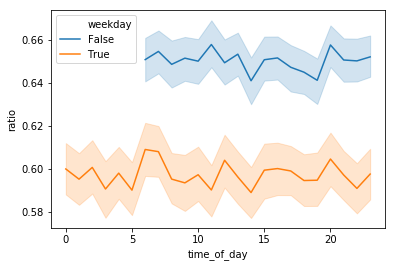

In [24]:
lineplot = sns.lineplot(x='time_of_day',y='ratio',hue='weekday',data=df_sim);

(Remember that by construction there is no data on weekends from midnight to 6am.) 

In the G&M paper, they do indeed separate out the data by day of the week. They show that the hourly trends hold, with one caveat: on weekends, the positive trend is delayed by two hours.

## Multiple regression

One way to tease apart these two potential predictors is through multiple regression, which is a statistical model of the relationship between a set of **predictors** (independent variables) and an **outcome** (dependent variable). A linear regression can be specified through the following canonical notation:

$ Y \sim X_1 + X_2 + \ldots + X_N.$

This states that $Y$ is the dependent variable, and that we will regress against the independent variables $X_1, X_2, \ldots, X_N$. Specifically, we will estimate coefficients for each $X_i$. The same notation can be used to specify more complicated regression models, including dummy variables (shown below) and interactions. In this case, the independent variables include the day of the week and the time of the day.

In python, regressions can be specified and performed using the `statsmodels` package, which uses a similar syntax to R's `glmnet`.


In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

The following formula specifies a regression with a feature for each hour, using the notation `C(time_of_day)`.

It also includes another indicator feature for whether the day is a weekday.

The outcome is the sentiment ratio.

In [26]:
formula = 'ratio ~ C(time_of_day) + weekday'

Now let's fit a regression, using ordinary least squares. A fancier approach would make use of the fact that sentiment ratio is constrained to the interval $[0,1]$, but we'll ignore this for now. We'll start by fitting the simulated data, where we do not expect a significant time-of-day effect.

In [60]:
model = smf.ols(formula='ratio ~ C(time_of_day) + weekday',data=df_sim)
results_sim = model.fit()
print(results_sim.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     38.09
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          1.04e-176
Time:                        16:19:19   Log-Likelihood:                -14415.
No. Observations:              100000   AIC:                         2.888e+04
Df Residuals:                   99975   BIC:                         2.912e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6524 

## Understanding this regression results

- The coefficient for `weekday` is almost exactly right ($.6 - .65 = -0.05$).
- As we hoped, the coefficients for `time_of_day` are almost all non-significant: the $p$-values are greater than $0.05$. Let's say a little more about this:
    - The **standard error** of each coefficient is the standard deviation of the estimation error of the coefficient. The standard error decreases with the square root of the dataset size.
    - The $t$ value is the coefficient divided by the standard error. Under the **null hypothesis** that time-of-day is unrelated to sentiment, we would expect the distribution of each $t$ value to follow a Student's $t$ distribution, whose mean is $0$, and whose variance is determined by the number of instances (but which rapidly approaches $1$ as the dataset size grows). 
    - Suppose a given coefficient has $t$ value equal to $\tau$. The **statistical significance** is based on the probability of having $|t| \geq |\tau|$ under the null hypothesis. This is the $p$ value, written $P > |t|$ in the summary.
    - It is customary to reject the null hypothesis when $p < .05$. However, in this case a correction is required, because we are performing multiple significance tests at the same time. In this case, we are performing more than 20 significance tests, so we would expect at least one coefficient to have $p<.05$ even if the null hypothesis were true. In a **Bonferroni correction**, the $p$-values are multiplied by the number of tests. The $p$-values for the `time-of-day` variables do not survive that correction at $p < .05$, but the $p$-value for the `weekday` variable does.
- The summary also includes some information about the goodness-of-fit, including $R^2, F, AIC$, and log-likelihood. These statistics can help to decide whether it is justified to use more complicated models (e.g., with more predictors).

## Multi-collinearity

Note that there is no predictor for "hour 0", which would be `C(time_of_day)[T.0]`. This predictor is completely determined by the other `time_of_day` variables. The same is true for `weekday[T.False]` with respect to `weekday[T.True]`. Including these predictors would make the estimation problem underdetermined: we could add a constant to all `time_of_day` predictors, and subtract the same constant from the `intercept` term. In regression, this is called **multi-collinearity**. It is impossible to interpret regression coefficients when the predictors are closely correlated. This isn't a problem for prediction, only for explanation, which is why closely related variables can be used in machine learning without concern.

## Visualizing the regression model

Let's plot the coefficients for the time-of-day predictors, along with their standard errors.

In [62]:
hour_coeffs = [0] # coefficients
hour_ses = [0] # standard errors

hours = range(1,24)
for hour in hours:
    hour_coeffs.append(results_sim.params[f'C(time_of_day)[T.{hour}]'])
    hour_ses.append(results_sim.bse[f'C(time_of_day)[T.{hour}]'])    

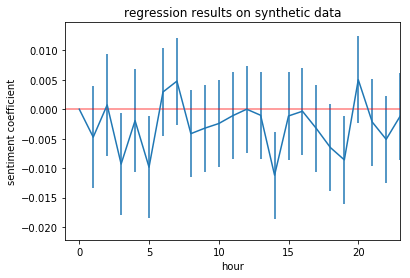

In [63]:
plt.errorbar([0] + list(hours), hour_coeffs, yerr=hour_ses)
plt.hlines(0,xmin=-1,xmax=hours[-1]+1,color='r',alpha=0.5)
plt.axis([-1,hours[-1],1.2 * min(hour_coeffs) - max(hour_ses), 1.2 * max(hour_coeffs) + max(hour_ses)])
plt.xlabel('hour')
plt.ylabel('sentiment coefficient')
plt.title('regression results on synthetic data');

## Back to the real data

Finally, let's do the same regression on the original data.

In [64]:
df['weekday'] = df['day_of_week'].apply(lambda x : x < 5)

In [65]:
model = smf.ols(formula='ratio ~ C(time_of_day) + weekday',data=df)
results_real = model.fit()
print(results_real.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.621
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           2.18e-26
Time:                        16:19:43   Log-Likelihood:                -49735.
No. Observations:               99999   AIC:                         9.952e+04
Df Residuals:                   99974   BIC:                         9.976e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6077 

Now several of the hour coefficients have $p$-values that are significant even after the Bonferroni correction.

In [66]:
hour_coeffs = [0] # coefficients
hour_ses = [0] # standard errors

hours = range(1,24)
for hour in hours:
    hour_coeffs.append(results_real.params[f'C(time_of_day)[T.{hour}]'])
    hour_ses.append(results_real.bse[f'C(time_of_day)[T.{hour}]'])    

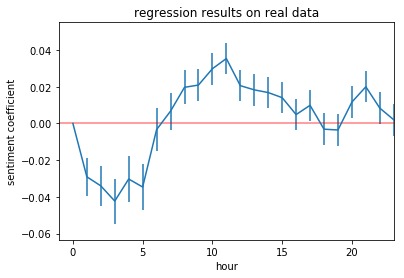

In [67]:
plt.errorbar([0] + list(hours), hour_coeffs, yerr=hour_ses)
plt.hlines(0,xmin=-1,xmax=hours[-1]+1,color='r',alpha=0.5)
plt.axis([-1,hours[-1],1.2 * min(hour_coeffs) - max(hour_ses), 1.2 * max(hour_coeffs) + max(hour_ses)])
plt.xlabel('hour')
plt.ylabel('sentiment coefficient')
plt.title('regression results on real data');

# Extension

Recall that our original data also includes the user ID, in the field `uid`. 

- Describe an alternative Simpson's paradox, in which the each individual writer is unaffected by day-of-week or time-of-day, but there is still a population-level effect.
- Use multiple regression to control for this issue in the provided data. As you can see below, adding `C(uid)` to the regression in statsmodel throws a `MemoryError`, so you will have to think of some other way to do this regression. 
- You might find `scipy.sparse.csr_matrix` to be useful.

In [87]:
model = smf.ols(formula='ratio ~ C(time_of_day) + weekday + C(uid)',data=df)

MemoryError: 